# Zillow’s Home Value Prediction (Zestimate)

## Description

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

Zillow Prize, a competition with a one million dollar grand prize, is challenging the data science community to help push the accuracy of the Zestimate even further. Winning algorithms stand to impact the home values of 110M homes across the U.S.

In this million-dollar competition, participants will develop an algorithm that makes predictions about the future sale prices of homes. The contest is structured into two rounds, the qualifying round which opens May 24, 2017 and the private round for the 100 top qualifying teams that opens on Feb 1st, 2018. In the qualifying round, you’ll be building a model to improve the Zestimate residual error. In the final round, you’ll build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give your model an edge over the competition.

Because real estate transaction data is public information, there will be a three-month sales tracking period after each competition round closes where your predictions will be evaluated against the actual sale prices of the homes. The final leaderboard won’t be revealed until the close of the sales tracking period.

`Link`: https://www.kaggle.com/competitions/zillow-prize-1/overview

## Evaluation: 
Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error.
The log error is defined as   
**logerror = log(Zestimate) - log(SalePrice)**


## Dataset Description:
`Train/Test split`

There are full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

The rest of the test data, which is used for calculating the private leaderboard, is all the properties in October 15, 2017, to December 15, 2017. This period is called the "sales tracking period", during which we will not be taking any submissions.

We have to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating score.

If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

## File description:
**properties_2016.csv** - all the properties with their home features for 2016. Note: Some 2017 new properties don't have any data yet except for their parcelid's. Those data points should be populated when properties_2017.csv is available.  
**properties_2017.csv** - all the properties with their home features for 2017 (released on 10/2/2017)  
**train_2016.csv** - the training set with transactions from 1/1/2016 to 12/31/2016  
**train_2017.csv** - the training set with transactions from 1/1/2017 to 9/15/2017 (released on 10/2/2017)  
**sample_submission.csv** - a sample submission file in the correct format

In [1]:
# Import necessary librairies
import gc 
import numpy as np # linear algebra
from numpy import hstack
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Datetime operations
import time

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Check the files available in the directory
import os
for dirname, _, filenames in os.walk('../Zillows-Home-Value-Prediction/Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

../Zillows-Home-Value-Prediction/Data\properties_2016.csv
../Zillows-Home-Value-Prediction/Data\properties_2017.csv
../Zillows-Home-Value-Prediction/Data\sample_submission.csv
../Zillows-Home-Value-Prediction/Data\train_2016_v2.csv
../Zillows-Home-Value-Prediction/Data\train_2017.csv
../Zillows-Home-Value-Prediction/Data\zillow-prize-1.zip
../Zillows-Home-Value-Prediction/Data\zillow_data_dictionary.xlsx


## Importing Datasets

In [2]:
import os

HOUSING_PATH = os.path.join("..", "Zillows-Home-Value-Prediction", "Data")
PROPERTIES_2016 = 'properties_2016.csv'
PROPERTIES_2017 = 'properties_2017.csv'
TRAIN_2016 = 'train_2016_v2.csv'
TRAIN_2017 = 'train_2017.csv'

def load_housing_data(housing_path=HOUSING_PATH):
    properties_2016 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2016))
    properties_2017 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2017))
    train_2016 = pd.read_csv(os.path.join(housing_path, TRAIN_2016))
    train_2017 = pd.read_csv(os.path.join(housing_path, TRAIN_2017))

    # Left join will ignore all properties that do not have a logerror (target variable) associated with them
    train_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
    train_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')
    
    # Union data for 2016 and 2017 into one dataframe
    all_properties = pd.concat([properties_2016, properties_2017], ignore_index=True)
    all_training = pd.concat([train_2016, train_2017], ignore_index=True)
    return all_properties, all_training

In [3]:
all_properties, housing = load_housing_data()
housing.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.028,2016-01-01,1.000,NaN,NaN,2.000,3.000,NaN,4.000,2.000,NaN,NaN,1684.000,1684.000,NaN,NaN,NaN,NaN,6037.000,NaN,2.000,NaN,NaN,NaN,2.000,34280990.000,-118488536.000,7528.000,NaN,NaN,NaN,NaN,NaN,0100,261.000,LARS,60371066.461,12447.000,3101.000,31817.000,96370.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1959.000,NaN,NaN,122754.000,360170.000,2015.000,237416.000,6735.880,NaN,NaN,60371066461001.000
1,14366692,-0.168,2016-01-01,NaN,NaN,NaN,3.500,4.000,NaN,NaN,3.500,NaN,NaN,2263.000,2263.000,NaN,NaN,NaN,NaN,6059.000,NaN,3.000,2.000,468.000,NaN,NaN,33668120.000,-117677556.000,3643.000,NaN,NaN,NaN,NaN,NaN,1,261.000,NaN,60590524.222,32380.000,1286.000,NaN,96962.000,0.000,NaN,1.000,NaN,NaN,NaN,NaN,2014.000,NaN,NaN,346458.000,585529.000,2015.000,239071.000,10153.020,NaN,NaN,NaN
2,12098116,-0.004,2016-01-01,1.000,NaN,NaN,3.000,2.000,NaN,4.000,3.000,NaN,NaN,2217.000,2217.000,NaN,NaN,NaN,NaN,6037.000,NaN,3.000,NaN,NaN,NaN,2.000,34136312.000,-118175032.000,11423.000,NaN,NaN,NaN,NaN,NaN,0100,261.000,PSR6,60374638.003,47019.000,3101.000,275411.000,96293.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1940.000,NaN,NaN,61994.000,119906.000,2015.000,57912.000,11484.480,NaN,NaN,60374638003004.000
3,12643413,0.022,2016-01-02,1.000,NaN,NaN,2.000,2.000,NaN,4.000,2.000,NaN,NaN,839.000,839.000,NaN,NaN,NaN,NaN,6037.000,NaN,2.000,NaN,NaN,NaN,2.000,33755800.000,-118309000.000,70859.000,NaN,NaN,NaN,NaN,NaN,010C,266.000,LAR3,60372963.002,12447.000,3101.000,54300.000,96222.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1987.000,NaN,NaN,171518.000,244880.000,2015.000,73362.000,3048.740,NaN,NaN,60372963002002.000
4,14432541,-0.005,2016-01-02,NaN,NaN,NaN,2.500,4.000,NaN,NaN,2.500,NaN,NaN,2283.000,2283.000,NaN,NaN,NaN,NaN,6059.000,NaN,2.000,2.000,598.000,NaN,NaN,33485643.000,-117700234.000,6000.000,1.000,NaN,NaN,NaN,1.000,122,261.000,NaN,60590423.381,17686.000,1286.000,NaN,96961.000,8.000,NaN,1.000,NaN,NaN,NaN,NaN,1981.000,2.000,NaN,169574.000,434551.000,2015.000,264977.000,5488.960,NaN,NaN,60590423381006.000


In [4]:
#checking the time to read data
start = time.time()
tempDf = pd.read_csv('../Zillows-Home-Value-Prediction/Data/properties_2016.csv')
train = pd.read_csv("../Zillows-Home-Value-Prediction/Data/train_2016_v2.csv", parse_dates=["transactiondate"])
dfTrain= train.merge(tempDf, how="left", on = "parcelid")
end= time.time()

print("Time taken: {}".format(end-start))

Time taken: 8.551473617553711


In [5]:
# Checking memory usage
train.info(verbose=False), tempDf.info(verbose=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Columns: 3 entries, parcelid to transactiondate
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Columns: 58 entries, parcelid to censustractandblock
dtypes: float64(52), int64(1), object(5)
memory usage: 1.3+ GB


(None, None)

Looks good

In [6]:
print("The shape {}".format(all_properties.shape))

all_properties.info()

The shape (5970434, 58)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5970434 entries, 0 to 5970433
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18

**Understanding:**  
There are total 5970434 or 5.9 Million properties available in the file.  
**Variable types distribution:** 53 Float64, 6 Object (Categorical) and 1 Integer (ParcelID)  


Check the NaN value

In [7]:
#all_properties.isna().sum()
# Checking what percentage of every column is missing
percent_missing = all_properties.isnull().sum() * 100 / len(all_properties)

percent_missing

parcelid                        0.000
airconditioningtypeid          72.751
architecturalstyletypeid       99.797
basementsqft                   99.945
bathroomcnt                     0.242
bedroomcnt                      0.241
buildingclasstypeid            99.575
buildingqualitytypeid          35.015
calculatedbathnbr               4.121
decktypeid                     99.423
finishedfloor1squarefeet       93.192
calculatedfinishedsquarefeet    1.686
finishedsquarefeet12            9.052
finishedsquarefeet13           99.743
finishedsquarefeet15           93.619
finishedsquarefeet50           93.192
finishedsquarefeet6            99.272
fips                            0.241
fireplacecnt                   89.519
fullbathcnt                     4.121
garagecarcnt                   70.282
garagetotalsqft                70.282
hashottuborspa                 98.006
heatingorsystemtypeid          38.437
latitude                        0.241
longitude                       0.241
lotsizesquar

In [8]:
moreThan90Per = percent_missing>90
moreThan90Per.sum()

20

20 columns have more than 90% data missing  
24 columns have more than 80% data missing  
29 columns have more than 50% data missing

### Duplicate Data

In [9]:
y = housing.logerror
y

0         0.028
1        -0.168
2        -0.004
3         0.022
4        -0.005
          ...  
167883   -0.002
167884    0.021
167885    0.013
167886    0.037
167887    0.007
Name: logerror, Length: 167888, dtype: float64

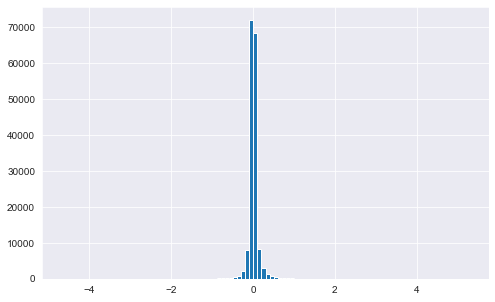

In [10]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [11]:
y.describe()

count   167888.000
mean         0.014
std          0.166
min         -4.655
25%         -0.025
50%          0.006
75%          0.039
max          5.263
Name: logerror, dtype: float64


 mu = 0.01 and sigma = 0.17



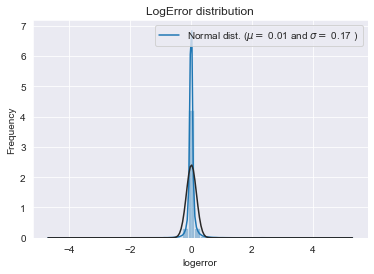

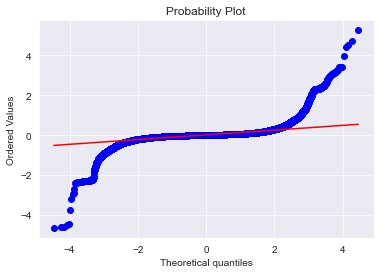

In [12]:
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [13]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.42817114871087414
Lowest allowed -0.400358536368391


In [14]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe 
housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [15]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0 
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(164538, 60)

In [16]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.21763714717335889
Lowest allowed -0.20059403149372554


In [17]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe 
housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [18]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0 
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(157763, 60)

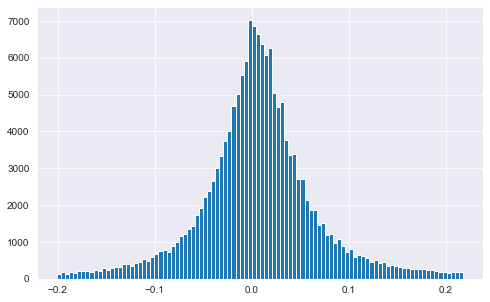

In [19]:
y.hist(bins=100, figsize=(8,5))
plt.show()


 mu = 0.01 and sigma = 0.06



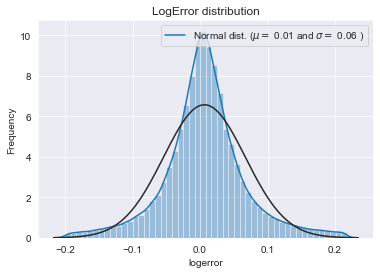

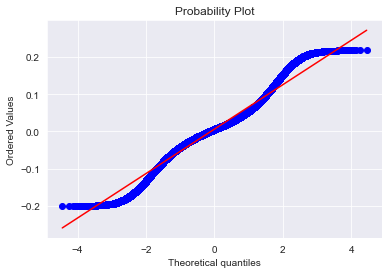

In [20]:
#Check the new distribution 
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

Create Test / Train Datasets
To avoid data snooping bias by overfitting to the test set, we need to create a test set, put it aside and never look at it. The most basic solution is to pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

Issue with approach: If you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.
Possible Solution: To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier).
For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.
Since parcelid is a unique identifier for each instance in the housing dataset, we can use it to implement the hash strategy outlined above.